In [1]:
import numpy as np
import scipy as sp

import autograd

import sys
sys.path.insert(0, './../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../src/vb_modeling/')

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

from numpy.polynomial.hermite import hermgauss

import gmm_clustering_lib as gmm_utils
from shift_only_lib import LinearSensitivity
import common_modeling_lib 
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

np.random.seed(453453)



# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [3]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [4]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

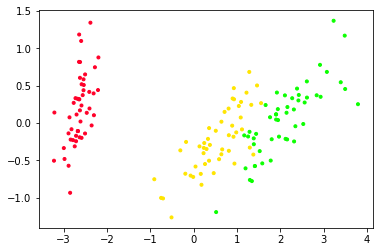

In [7]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

In [8]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Set prior params

In [42]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(1.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [43]:
print(prior_params)

prior_params:
	alpha: 1.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Set up model

In [44]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

# Set inits

In [45]:
set_truth = False

In [46]:
if set_truth: 
    # set to the true centroids: 
    centroid_init = np.zeros((dim, k_approx))
    info_init = np.zeros((k_approx, dim, dim))
    for k in range(k_approx): 
        if k < 3: 
            k_indx = np.argwhere(iris_species == k).flatten()
            centroid_k = np.mean(model.y[k_indx, :], axis = 0)

            resid_k = model.y[k_indx, :] - centroid_k

            cov_init = np.dot(resid_k.T, resid_k)

            info_init[k, :, :] = np.linalg.inv(cov_init)
            centroid_init[:, k] = centroid_k
        else: 
            info_init[k, :, :] = np.eye(dim)
    
    model.vb_params['global']['centroids'].set(centroid_init)
    model.vb_params['global']['gamma'].set(info_init)
    
    model.set_optimal_z()
    
    init_global_free_param = model.global_vb_params.get_free()
    
        
    
else: 
    # run k-means init
    n_kmeans_init = 50
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)


# look at initializations

In [47]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

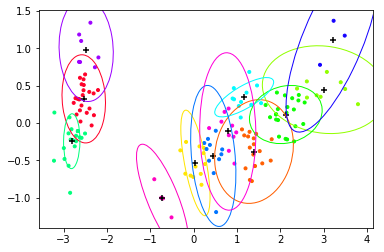

In [48]:
init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

In [49]:
# %%R -i init_clusters -i init_centroids -w 4 -h 3 --units in -r 200
#     k_approx <- dim(init_centroids)[2]
#     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
#     pca_centroids_init$cluster <- as.factor(seq(1, k_approx, by = 1))
#     # TODO: plot the centroids too 

#     # add our initial clusterings to the dataframe
#     df_pca$init_clusters <- as.factor(init_clusters)
    
#     # plot
#     ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = init_clusters), size = 0.5) + 
#         theme(legend.position="none") 

# Optimize!

In [50]:
t0 = time.time()
best_param, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model.optimize_full(init_global_free_param,
    init_max_iter=100,
    final_max_iter=500)
t_newton = time.time() - t0

print('done. ')

Iter: 0	 RMSE: 5.598913912817113	 Objective: 10571.769433099784
Iter: 10	 RMSE: 11.258890098388095	 Objective: 5404.565976273536
Iter: 20	 RMSE: 12.640981713584805	 Objective: 3354.8348723221047
Iter: 30	 RMSE: 13.710661439497194	 Objective: 631.2701397809864
Iter: 40	 RMSE: 11.669064597758597	 Objective: 106.99884136096853
Iter: 50	 RMSE: 11.293956914167277	 Objective: -96.8025154506351
Iter: 60	 RMSE: 10.510661543806455	 Objective: -205.62487579973885
Iter: 70	 RMSE: 10.514638885044606	 Objective: -283.20751623080275
Iter: 80	 RMSE: 10.577839128432952	 Objective: -310.3693414953517
Iter: 90	 RMSE: 10.315465418637206	 Objective: -319.454175336204
Iter: 100	 RMSE: 10.400107779574578	 Objective: -324.08708309731037
Iter: 110	 RMSE: 10.386824563314544	 Objective: -325.66720196976047
         Current function value: -327.107989
         Iterations: 100
         Function evaluations: 114
         Gradient evaluations: 114
Iter: 120	 RMSE: 9.875227058707372	 Objective: -336.6489799713542
It

In [51]:
newton_results = deepcopy(model)

In [52]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

### look at bnp clusters

In [53]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

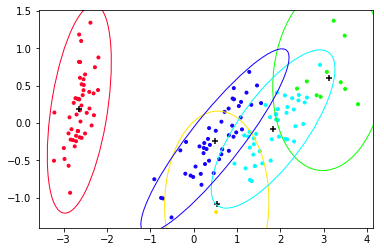

In [54]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

In [55]:
# %%R -i bnp_clusters -i bnp_centroids -w 4 -h 3 --units in -r 200
# #     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# #     pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# # add our bnp clusterings to the dataframe
# df_pca$bnp_clusters <- as.factor(bnp_clusters)

# # plot
# ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#     theme(legend.position="none") 

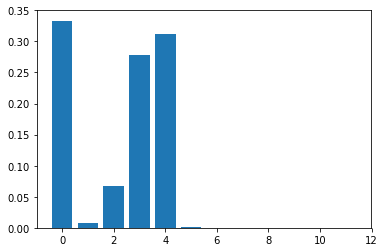

In [56]:
cluster_weights = np.sum(newton_results.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
plt.bar(np.arange(len(cluster_weights)), cluster_weights); 

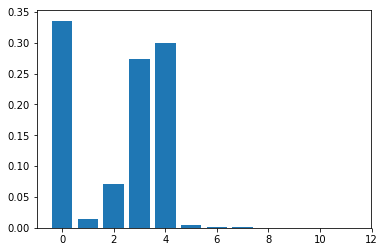

In [57]:
posterior_weights = model.get_e_cluster_probabilities()
plt.bar(np.arange(len(posterior_weights)), posterior_weights); 

(array([  1.,   1.,   0.,   1.,   2.,   1.,   3.,   2.,   7., 132.]),
 array([0.52661961, 0.57395765, 0.62129569, 0.66863373, 0.71597177,
        0.76330981, 0.81064784, 0.85798588, 0.90532392, 0.95266196,
        1.        ]),
 <a list of 10 Patch objects>)

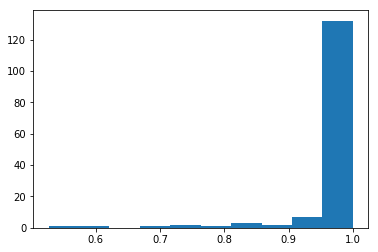

In [58]:
plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))

# Sensitivity

In [59]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = LinearSensitivity(model, moment_model)

KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [60]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)


In [61]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))


0.06418997403300389 2452.4201727260734


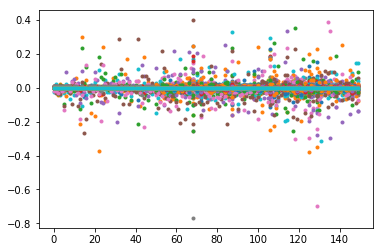

In [62]:
# sensitivity to data
plt.plot(linear_sens.data_sens_mat.T, '.');


# Functional Sensitivty

In [63]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)

get_g_eta = autograd.jacobian(get_stick_length_from_free_param, argnum = 1)
g_eta = get_g_eta(model, best_param)


In [64]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_sticks = np.zeros((k_approx - 1, len(theta)))
for k in range(k_approx - 1): 
    total_influence_sticks += np.dot(g_eta, linear_sens.influence_function(theta, k))


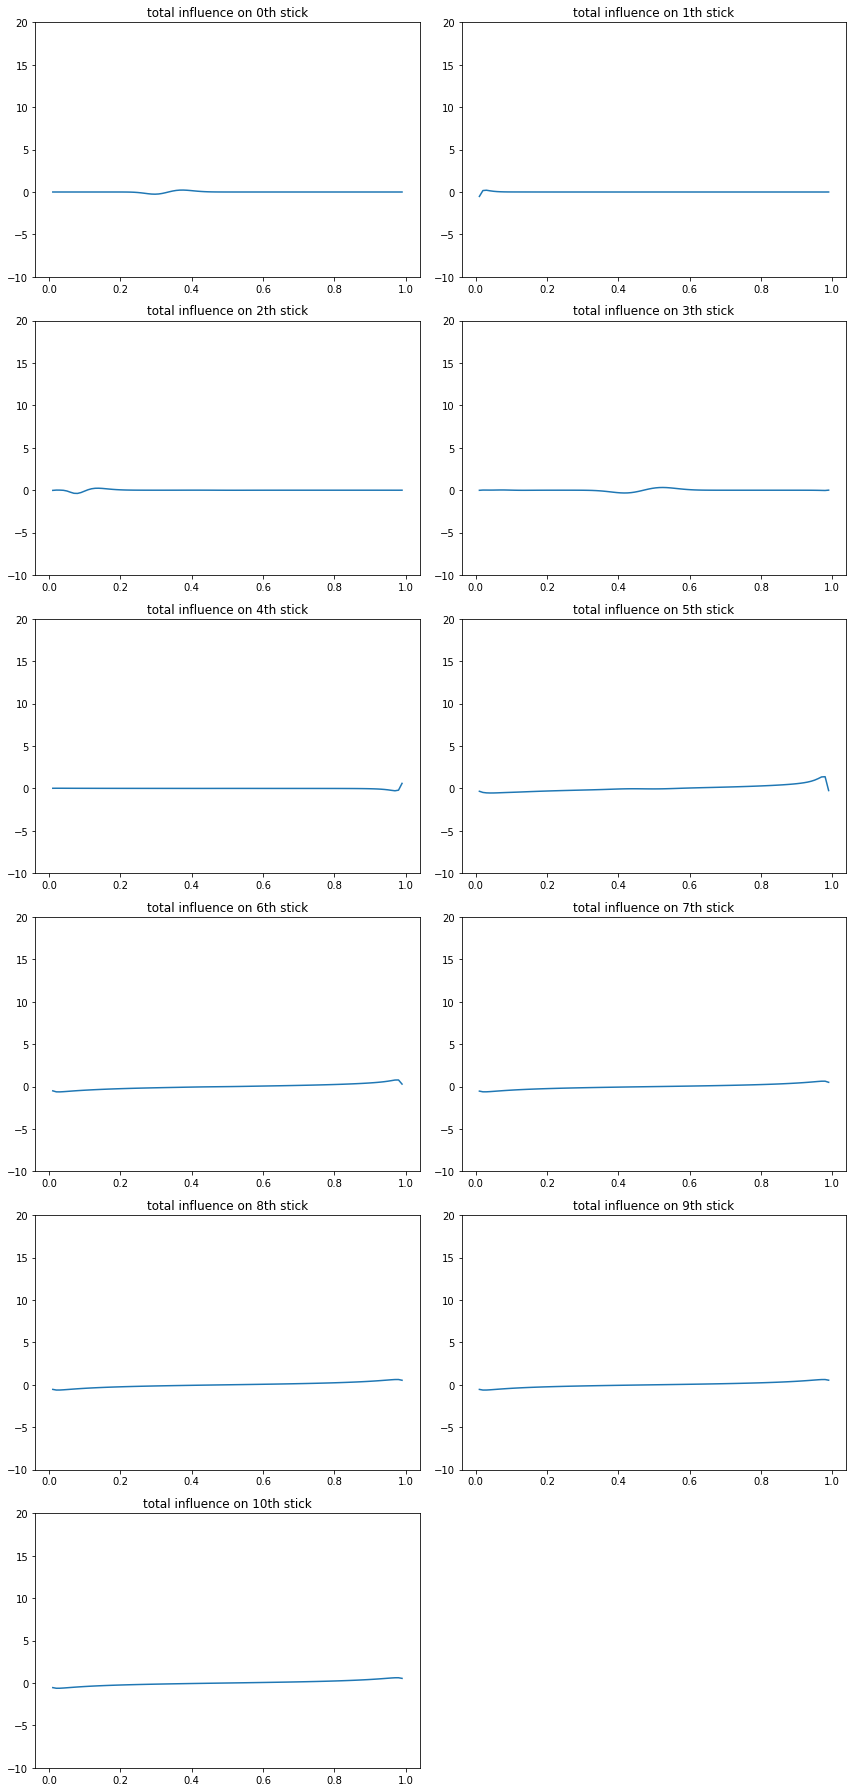

In [65]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, total_influence_sticks[k, :])
    axarr[indx1, indx2].set_ylim([-10.0, 20.0])
    axarr[indx1, indx2].set_title('total influence on {}th stick'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])

f.tight_layout()


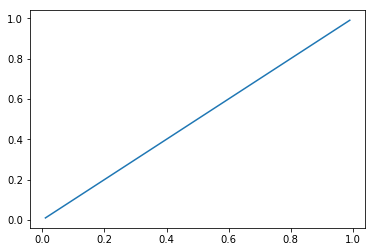

In [66]:
# lets choose a perturbation 

u = lambda x : x

plt.plot(theta, u(theta))

In [67]:
# get functional sensitivity
fun_sens_mat = linear_sens.get_functional_sensitivity(u)

In [68]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [69]:
# Perturb and re-optimize
model_u_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = u)

pert_u_opt_free_param = \
    model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


Iter: 0	 RMSE: 7.866127650688319	 Objective: -352.4512820205539
Iter: 10	 RMSE: 7.867878842942231	 Objective: -352.4768522393955
Iter: 20	 RMSE: 7.866307306347102	 Objective: -352.5361856969862
Iter: 30	 RMSE: 7.864226021230003	 Objective: -352.5603953545179
Iter: 40	 RMSE: 7.865495448888733	 Objective: -352.56592129857194
Iter: 50	 RMSE: 7.865082757298476	 Objective: -352.56760128898713
Iter: 60	 RMSE: 7.864513390724041	 Objective: -352.56783958606655
Iter: 70	 RMSE: 7.864426732702303	 Objective: -352.5678479960375
Iter: 80	 RMSE: 7.864430838052273	 Objective: -352.56784884914833
Iter: 90	 RMSE: 7.864428488602526	 Objective: -352.56784889591444
Optimization terminated successfully.
         Current function value: -352.567849
         Iterations: 77
         Function evaluations: 91
         Gradient evaluations: 91
         Current function value: -352.567849
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 

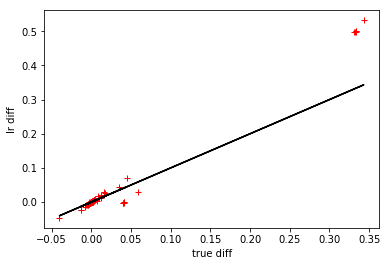

In [70]:
lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1))

diff_vec = pert_u_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


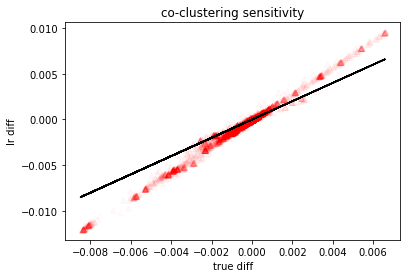

In [71]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_og = np.matmul(e_z_orig, e_z_orig.T)

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_pert = np.matmul(e_z_pert, e_z_pert.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_lrvb = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_clustering_pert - co_clustering_og).flatten()
lr_diff_vec = (co_clustering_lrvb - co_clustering_og).flatten()

plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', alpha = 0.01)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


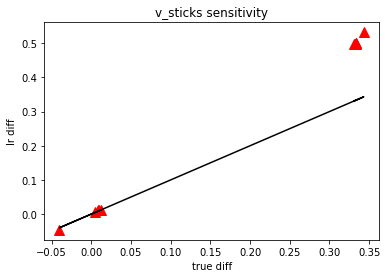

In [72]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
v_sticks_orig = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
v_sticks_pert = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
v_sticks_lr = linear_sens.moment_model.moment_params['v_sticks'].get()

diff_vec = (v_sticks_pert - v_sticks_orig).flatten()
lr_diff_vec = (v_sticks_lr - v_sticks_orig).flatten()

plt.title('v_sticks sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', markersize = 10)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


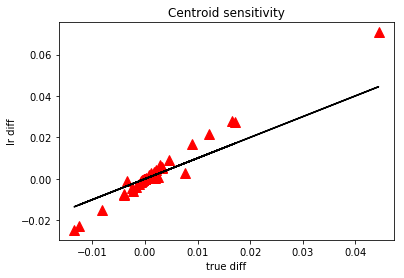

In [73]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
beta_og = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
beta_lrvb = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec1 = (beta_pert - beta_og).flatten()
lr_diff_vec1 = (beta_lrvb - beta_og).flatten()

plt.title('Centroid sensitivity')
plt.plot(diff_vec1, lr_diff_vec1, 'r^', markersize = 10)
plt.plot(diff_vec1, diff_vec1, 'k') 

plt.xlabel('true diff')
plt.ylabel('lr diff')
